# Student Performance from Game Play Using TensorFlow Decision Forests

## Import the Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import f1_score

## Load the Dataset

In [2]:
# Reference: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/384359
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    
    'hover_duration':np.float32,
    
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',

    'fullscreen': np.int32,
    'hq': np.int32,
    'music': np.int32,

    'level_group':'category'}

dataset_df = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes)

In [3]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int64   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           uint8   
 6   page            float64 
 7   room_coor_x     float32 
 8   room_coor_y     float32 
 9   screen_coor_x   float32 
 10  screen_coor_y   float32 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      int32   
 17  hq              int32   
 18  music           int32   
 19  level_group     category
dtypes: category(7), float32(5), float64(1), int32(4), int64(2), uint8(1)
memory usage: 1.7 GB


## Load the labels

In [4]:
labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')

In [5]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

# Prepare the dataset

In [6]:
CATEGORICAL = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['page', 'location_x_diff', 'location_y_diff','hover_duration', 'elapsed_time']
OPTIONAL = ['music', 'fullscreen', 'hq']

# Lots..
NAMES = dataset_df['name'].unique()
EVENTS = dataset_df['event_name'].unique()

TEXT_LISTS = dataset_df['text'].unique()
FQID_LISTS = dataset_df['fqid'].unique()

In [7]:
# df.fillna(df.mean()), df.where(pd.notnull(df), df.mean(), axis='columns')
def feature_engineer(dataset_df):
    dataset_df['elapsed_time_diff'] = (
        (dataset_df['elapsed_time'] - dataset_df['elapsed_time'].shift(1))
        .fillna(0)
        .clip(lower=0, upper=1e9)
    )
    dataset_df['location_x_diff'] = (
        (dataset_df['room_coor_x'] - dataset_df['room_coor_x'].shift(1))
        .abs()
    )
    dataset_df['location_y_diff'] = (
        (dataset_df['room_coor_y'] - dataset_df['room_coor_y'].shift(1))
        .abs()
    )
    
    dfs = []
    
    # NUMERICAL
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('max')
        tmp.name = tmp.name + '_max'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('min')
        tmp.name = tmp.name + '_min'
        dfs.append(tmp)
    
    # EVNETS
#     for c in EVENTS: 
#         dataset_df[c] = (dataset_df.event_name == c).astype('int8')
#     for c in EVENTS: 
#         tmp = dataset_df[dataset_df[c] == 1].groupby(['session_id', 'level_group'])[c].sum()
#         tmp.name = c + '_count'
#         dfs.append(tmp)
#     for c in EVENTS: 
#         tmp = dataset_df[dataset_df[c] == 1].groupby(['session_id', 'level_group'])[c].std()
#         tmp.name = c + '_std'
#         dfs.append(tmp)
#     for c in EVENTS: 
#         tmp = dataset_df[dataset_df[c] == 1].groupby(['session_id', 'level_group'])[c].mean()
#         tmp.name = c + '_mean'
#         dfs.append(tmp)
#     for c in EVENTS: 
#         tmp = dataset_df[dataset_df[c] == 1].groupby(['session_id', 'level_group'])[c].max()
#         tmp.name = c + '_max'
#         dfs.append(tmp)
#     for c in EVENTS: 
#         tmp = dataset_df[dataset_df[c] == 1].groupby(['session_id', 'level_group'])[c].min()
#         tmp.name = c + '_min'
#         dfs.append(tmp)
        
#     for c in EVENTS:
#         tmp = dataset_df[dataset_df[c] == 1].groupby(['session_id', 'level_group'])['elapsed_time_diff'].agg('mean')
#         tmp.name = c + '_time_average'
#         dfs.append(tmp)
        
        
    #OPTIONALS
    for c in OPTIONAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in OPTIONAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in OPTIONAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    for c in OPTIONAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('min')
        tmp.name = tmp.name + '_min'
        dfs.append(tmp)
    for c in OPTIONAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('max')
        tmp.name = tmp.name + '_max'
        dfs.append(tmp)   
        
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [8]:
dataset_df = feature_engineer(dataset_df)

In [9]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70686 entries, 20090312431273200 to 22100221145014656
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   level_group           70686 non-null  category
 1   page_mean             70686 non-null  float64 
 2   location_x_diff_mean  70686 non-null  float32 
 3   location_y_diff_mean  70686 non-null  float32 
 4   hover_duration_mean   70686 non-null  float32 
 5   elapsed_time_mean     70686 non-null  float64 
 6   page_std              70686 non-null  float64 
 7   location_x_diff_std   70686 non-null  float64 
 8   location_y_diff_std   70686 non-null  float64 
 9   hover_duration_std    70686 non-null  float64 
 10  elapsed_time_std      70686 non-null  float64 
 11  page_sum              70686 non-null  float64 
 12  location_x_diff_sum   70686 non-null  float32 
 13  location_y_diff_sum   70686 non-null  float32 
 14  hover_duration_sum    7068

In [10]:
num_rows, num_cols = dataset_df.shape

print("#row:", num_rows)
print("#col:", num_cols)

#row: 70686
#col: 41


In [11]:
train_session_id = dataset_df.index
session_df = pd.DataFrame(train_session_id)
session_df.name = 'session_id'

## PCA

In [12]:
from sklearn.decomposition import PCA

data_for_pca = dataset_df.drop(['level_group'], axis=1)
pca = PCA(n_components=40)
pca_result = pca.fit_transform(data_for_pca)
pca_dataset_df = pd.DataFrame(pca_result)

dataset_df.reset_index(drop=True, inplace=True) 
dataset_df = pd.concat([session_df,dataset_df[['level_group']], pca_dataset_df], axis=1)

In [13]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70686 entries, 0 to 70685
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   session_id   70686 non-null  int64   
 1   level_group  70686 non-null  category
 2   0            70686 non-null  float64 
 3   1            70686 non-null  float64 
 4   2            70686 non-null  float64 
 5   3            70686 non-null  float64 
 6   4            70686 non-null  float64 
 7   5            70686 non-null  float64 
 8   6            70686 non-null  float64 
 9   7            70686 non-null  float64 
 10  8            70686 non-null  float64 
 11  9            70686 non-null  float64 
 12  10           70686 non-null  float64 
 13  11           70686 non-null  float64 
 14  12           70686 non-null  float64 
 15  13           70686 non-null  float64 
 16  14           70686 non-null  float64 
 17  15           70686 non-null  float64 
 18  16           70686 non-nul

In [14]:
num_rows, num_cols = dataset_df.shape

print("#row:", num_rows)
print("#col:", num_cols)

#row: 70686
#col: 42


In [15]:
# dataset_df = dataset_df.drop(columns = [1, 2, 32, 39, 5, 6, 7, 8, 11, 14,19, 24, 29, 36])
# dataset_df = dataset_df.drop(columns = [1, 2, 32, 39])

In [16]:
FEATURES = [c for c in dataset_df.columns if c != 'level_group']
# ALL_USERS = dataset_df.index.unique()
ALL_USERS = dataset_df['session_id'].unique()


gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}
evaluation_dict ={}

In [17]:
for i, (train_index, test_index) in enumerate(gkf.split(X=dataset_df, groups=dataset_df.index)):
    print('-'*25)
    print('    <<<  Fold ',i+1, ' >>>')
    print('-'*25)
    
    # default: 0.684 ~ 0.685
    xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'max_depth': 5,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'tree_method':'hist',
        'subsample':0.8,
        'colsample_bytree': 0.4,
        'use_label_encoder' : False
    }

    xgb_params_1 = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'max_depth': 5,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'tree_method':'hist',
        'subsample':0.5,
        'colsample_bytree': 1,
        'use_label_encoder' : False,
        
        ### Parameters Tuning.. 
        'gamma': 5,
        'min_child_weight': 8,
        'colsample_bytree': 0.5
    }
    
    xgb_params_test = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.1,
        'max_depth': 7,
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'tree_method':'hist',
        'subsample':0.7,
        'colsample_bytree': 0.7,
        'use_label_encoder' : False,
                
        ### Parameters Tuning.. 
        'random_state': 2,
        'gamma': 5,
        'min_child_weight': 1,
        'colsample_bytree': 0.5
    }
    
    for q_no in range(1,19):

        # Select level group for the question based on the q_no.
        if q_no<=3: grp = '0-4'
        elif q_no<=13: grp = '5-12'
        elif q_no<=22: grp = '13-22'


        # TRAIN DATA
        train_x = dataset_df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
#         train_users = train_x.index.values
        train_users = train_x['session_id'].values


        train_y = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = dataset_df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
#         valid_users = valid_x.index.values
        valid_users = valid_x['session_id'].values

        valid_y = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]

        # We will now create the Gradient Boosted Trees Model with default settings. 
        # By default the model is set to train for a classification task.
        xgb = XGBClassifier(**xgb_params_test)
        xgb.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{q_no}({xgb.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{q_no}'] = xgb
        oof.loc[valid_users, q_no-1] = xgb.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]  
    print()

-------------------------
    <<<  Fold  1  >>>
-------------------------
1(46), 2(65), 3(58), 4(42), 5(37), 6(46), 7(49), 8(35), 9(45), 10(22), 11(53), 12(39), 13(37), 14(62), 15(14), 16(34), 17(21), 18(74), 
-------------------------
    <<<  Fold  2  >>>
-------------------------
1(64), 2(65), 3(60), 4(34), 5(41), 6(30), 7(30), 8(18), 9(53), 10(23), 11(19), 12(50), 13(29), 14(39), 15(43), 16(31), 17(45), 18(47), 
-------------------------
    <<<  Fold  3  >>>
-------------------------
1(38), 2(59), 3(58), 4(41), 5(22), 6(36), 7(40), 8(22), 9(42), 10(36), 11(27), 12(41), 13(29), 14(32), 15(36), 16(32), 17(23), 18(73), 
-------------------------
    <<<  Fold  4  >>>
-------------------------
1(48), 2(120), 3(57), 4(50), 5(43), 6(28), 7(32), 8(17), 9(28), 10(26), 11(35), 12(40), 13(34), 14(26), 15(51), 16(25), 17(21), 18(40), 
-------------------------
    <<<  Fold  5  >>>
-------------------------
1(59), 2(57), 3(50), 4(78), 5(22), 6(74), 7(50), 8(27), 9(48), 10(24), 11(32), 12(51)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

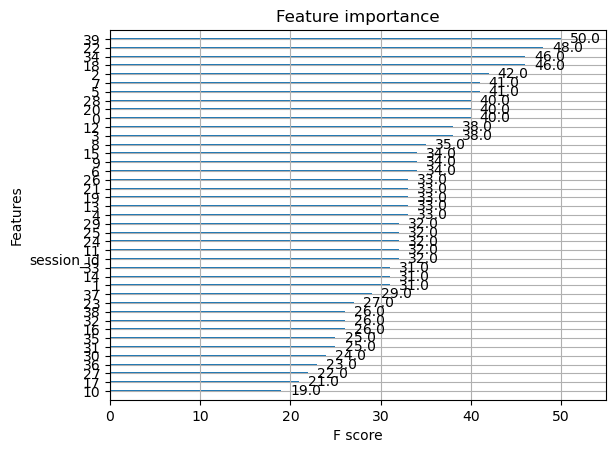

In [18]:
from xgboost import plot_importance

fig, ax = plt.subplots()
plot_importance(xgb, ax=ax)

In [19]:
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = labels.loc[labels.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [20]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

In [21]:
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

Q0: F1 = 0.6126173643122067
Q1: F1 = 0.49654118284553705
Q2: F1 = 0.49059145038980145
Q3: F1 = 0.607761305998608
Q4: F1 = 0.5596763974586314
Q5: F1 = 0.6008112077050709
Q6: F1 = 0.5801079640539505
Q7: F1 = 0.5226210836917788
Q8: F1 = 0.5938312756049715
Q9: F1 = 0.4832562915815136
Q10: F1 = 0.5809551099240831
Q11: F1 = 0.4897559543883049
Q12: F1 = 0.4329638506084018
Q13: F1 = 0.5909145973248302
Q14: F1 = 0.4648979016692207
Q15: F1 = 0.4886457054987019
Q16: F1 = 0.5357445098237812
Q17: F1 = 0.4872364039955605
==> Overall F1 = 0.6728731561532453


In [22]:
# # Reference
# # https://www.kaggle.com/code/philculliton/basic-submission-demo
# # https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook

# import jo_wilder
# env = jo_wilder.make_env()
# iter_test = env.iter_test()

# limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

# for (test, sample_submission) in iter_test:
#     # FEATURE ENGINEER TEST DATA
#     df = feature_engineer(test)
#     # INFER TEST DATA
#     grp = test.level_group.values[0]
#     a,b = limits[grp]
#     for t in range(a,b):
#         xgb = models[f'{grp}_{t}']
#         p = xgb.predict_proba(df[FEATURES].astype('float32'))[0,1]
#         mask = sample_submission.session_id.str.contains(f'q{t}')
#         sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
#     env.predict(sample_submission)

In [23]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    # FEATURE ENGINEER TEST DATA
    test_data = feature_engineer(test)
    #test
    test_session_id = test_data.index
    test_session_df = pd.DataFrame(test_session_id)
    test_session_df.name = 'session_id'
    
    test_data_for_pca = test_data.drop(['level_group'], axis=1)
    pca_test_result = pca.transform(test_data_for_pca)
    pca_test_df = pd.DataFrame(pca_test_result)
    
    test_data.reset_index(drop=True, inplace=True) 
    test_data = pd.concat([test_session_df,test_data[['level_group']],pca_test_df], axis=1)
    #test
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        xgb = models[f'{grp}_{t}']
        p = xgb.predict_proba(test_data[FEATURES].astype('float32'))[0,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
